# Import


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install pytesseract

In [ ]:
!apt-get update
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,537 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,469 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/ma

In [ ]:
!apt-get install tesseract-ocr-eng

Reading package lists... Done
Building dependency tree... Done

tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1.1).
tesseract-ocr-eng set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.


In [ ]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


# Library

In [ ]:
import cv2
import pytesseract
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from google.colab import files

# OCR

In [ ]:
# Ensure Tesseract is correctly configured
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Function to clean and correct extracted values
def clean_value(value):
    # Replace misinterpreted "9" (common OCR error for "g") when detected incorrectly
    corrected_value = re.sub(r'9(\D|$)', 'g', value)  # Replace '9' if followed by a non-digit or end of string
    # Extract only valid numeric characters (digits and dots)
    cleaned_value = ''.join([char for char in corrected_value if char.isdigit() or char == '.'])
    return cleaned_value if cleaned_value else None

# Function to extract nutritional values from OCR text
def extract_nutrition_info(ocr_text):
    lines = ocr_text.split('\n')
    sugar, fat, serving_size = None, None, None

    for line in lines:
        # Normalize common OCR errors
        line = line.replace("Guta", "Gula").replace("gula", "Gula").replace("LemakJenuh", "Lemak Jenuh").replace("TakaranSaji", "Takaran Saji").replace("sqji", "saji").replace("Og", "0g").replace(",", ".").strip()

        # Detect and extract sugar content
        if 'gula' in line.lower() or 'sugar' in line.lower():
            sugar = clean_value(line)

        # Detect and extract fat content
        elif 'lemak' in line.lower() or 'fat' in line.lower():
            fat = clean_value(line)

        # Detect and extract serving size
        elif 'saji' in line.lower() or 'serving size' in line.lower():
            serving_size = clean_value(line)

    return sugar, fat, serving_size

# Function to normalize values to a standard serving size of 100g
def normalize_to_100g(sugar, fat, serving_size):
    try:
        # Convert serving size to float after cleaning 'g'
        serving_size = float(serving_size.replace('g', '').strip())
        sugar_100g = (float(sugar) / serving_size) * 100 if sugar else None
        fat_100g = (float(fat) / serving_size) * 100 if fat else None
        return sugar_100g, fat_100g
    except (ValueError, AttributeError):
        print("Error in normalization. Please check the values:", sugar, fat, serving_size)
        return None, None

# Function to read image and extract information
def extract_info_from_images():
    # Upload image
    print("Silakan unggah gambar...")
    uploaded = files.upload()  # Note: This is for use in Jupyter environments

    for filename in uploaded.keys():
        # Read the image file
        img = cv2.imread(filename)

        # Preprocess the image (grayscale and thresholding)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Perform OCR
        ocr_text = pytesseract.image_to_string(thresh, lang='eng')
        print("\nHasil OCR untuk gambar", filename, ":\n")
        print(ocr_text)

        # Extract nutritional information
        sugar, fat, serving_size = extract_nutrition_info(ocr_text)
        print("\nInformasi Ekstraksi:")
        print(f"Gula: {sugar if sugar else 'Tidak terdeteksi'}")
        print(f"Lemak: {fat if fat else 'Tidak terdeteksi'}")
        print(f"Serving Size: {serving_size if serving_size else 'Tidak terdeteksi'}")

    return sugar, fat, serving_size

# Grading

In [ ]:
# Load dataset untuk model klasifikasi
df = pd.read_csv('food_grade_dataset_revisi.csv', sep=';')

def get_correct_grade(sugar_100g, fat_100g):
    if sugar_100g <= 1: sugar_grade = 'A'
    elif 1 < sugar_100g <= 5: sugar_grade = 'B'
    elif 5 < sugar_100g <= 10: sugar_grade = 'C'
    else: sugar_grade = 'D'

    if fat_100g <= 0.7: fat_grade = 'A'
    elif 0.7 < fat_100g <= 1.2: fat_grade = 'B'
    elif 1.2 < fat_100g <= 2.8: fat_grade = 'C'
    else: fat_grade = 'D'

    return max(sugar_grade, fat_grade)

# Validasi dataset
mismatches = 0
for _, row in df.iterrows():
    correct_grade = get_correct_grade(row['Sugar per 100g'], row['Fat per 100g'])
    if correct_grade != row['Grade']:
        mismatches += 1
        print(f"\nMismatch found:")
        print(f"Sugar={row['Sugar per 100g']:.1f}, Fat={row['Fat per 100g']:.1f}")
        print(f"Dataset Grade: {row['Grade']}, Should be: {correct_grade}")

print(f"\nTotal mismatches found: {mismatches}")
df['Corrected_Grade'] = df.apply(lambda row: get_correct_grade(row['Sugar per 100g'], row['Fat per 100g']), axis=1)

def create_boundary_features(sugar_100g, fat_100g):
    features = np.zeros(6)
    features[0] = sugar_100g
    features[1] = fat_100g
    features[2] = abs(sugar_100g - 1)
    features[3] = abs(sugar_100g - 5)
    features[4] = abs(sugar_100g - 10)
    features[5] = abs(fat_100g - 2.8)
    return features

X = np.array([create_boundary_features(s, f) for s, f in zip(df['Sugar per 100g'], df['Fat per 100g'])])
y = df['Corrected_Grade'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Model klasifikasi grade
def create_boundary_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(24, activation='relu', input_shape=(6,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Training model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model = create_boundary_model()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Prediksi grade
def predict_grade(sugar, fat, serving_size):
    # Normalize values to 100g
    sugar_100g = (sugar / serving_size) * 100
    fat_100g = (fat / serving_size) * 100

    # Create features
    features = create_boundary_features(sugar_100g, fat_100g).reshape(1, -1)

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict grade
    pred = model.predict(features_scaled)
    grade = le.inverse_transform([np.argmax(pred)])[0]

    # Calculate expected grade
    expected_grade = get_correct_grade(sugar_100g, fat_100g)

    return grade, expected_grade, sugar_100g, fat_100g

# Model evaluation function
def evaluate_model():
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # AUC
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    # Precision, Recall, Accuracy
    precision = precision_score(y_test, y_pred_class, average='weighted')
    recall = recall_score(y_test, y_pred_class, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_class)

    print(f"\nEvaluating model...")
    print(f"AUC (Area Under the Curve): {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Input dan prediksi berdasarkan OCR
def extract_info_from_images_and_predict():
    sugar, fat, serving_size = extract_info_from_images()  # Get values from OCR

    if sugar and fat:
        try:
            # Handle missing serving size
            if serving_size:
                sugar_100g, fat_100g = normalize_to_100g(sugar, fat, serving_size)
            else:
                print("\nServing size not detected. Assuming values are for 100g.")
                sugar_100g = float(sugar)
                fat_100g = float(fat)

            if sugar_100g is not None and fat_100g is not None:
                # Predict grade
                grade, expected_grade, _, _ = predict_grade(sugar_100g, fat_100g, 100)
                print(f"\nGrade yang diprediksi: {grade}, Grade yang diharapkan: {expected_grade}")
                print(f"Sugar per 100g: {sugar_100g:.2f}g, Fat per 100g: {fat_100g:.2f}g")

                # Evaluate the model
                evaluate_model()
            else:
                print("\nNormalization failed. Ensure data is complete and valid.")
        except Exception as e:
            print(f"Error during prediction: {e}")
    else:
        print("\nPrediction cannot proceed due to incomplete data.")

# Jalankan fungsi ekstraksi dan prediksi
extract_info_from_images_and_predict()


Total mismatches found: 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.2575 - loss: 2.1807 - val_accuracy: 0.6222 - val_loss: 1.4419 - learning_rate: 0.0010
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2682 - loss: 1.8883 - val_accuracy: 0.6444 - val_loss: 1.4053 - learning_rate: 0.0010
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3824 - loss: 1.5638 - val_accuracy: 0.6222 - val_loss: 1.3653 - learning_rate: 0.0010
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3901 - loss: 1.5763 - val_accuracy: 0.6000 - val_loss: 1.3247 - learning_rate: 0.0010
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4382 - loss: 1.3902 - val_accuracy: 0.5333 - val_loss: 1.2868 - learning_rate: 0.0010
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5282 - loss: 1.1949 - val_accuracy: 0.4667 - val_loss: 1.2502 - learning_rate: 0.0010
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6170 - loss: 0.9956 - val_accuracy: 0.4889 

Saving coba1.jpg to coba1 (6).jpg

Hasil OCR untuk gambar coba1 (6).jpg :

INFORMASI NILAI GIZI

Takaran sqji 13 g
19 Sajian per Kemasan

JUMLAH PERSAJIAN
Energi Total

Energi dari lemak

Energi dari lemak Jenuh

SL
%AKG*

Lemak Total lg \%
Lemak Jenuh Og 0%
Protein 3g 6%
Karbohidrat Total 8g 3%
Gula 6g

Garam (Natrium) 10mg "%

A

*Persen AKG berdasarkan kebutuhan energ! 2.150 kkal.

Kebutuhan energi anda mungkin lebih tinggi atau
lebih rendah

 


Informasi Ekstraksi:
Gula: 6
Lemak: 00
Serving Size: Tidak terdeteksi

Serving size not detected. Assuming values are for 100g.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step

Grade yang diprediksi: B, Grade yang diharapkan: C
Sugar per 100g: 6.00g, Fat per 100g: 0.00g
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Evaluating model...
AUC (Area Under the Curve): 0.9618
Precision: 0.5775
Recall: 0.6354
Accuracy: 0.6354


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualizing Training History...


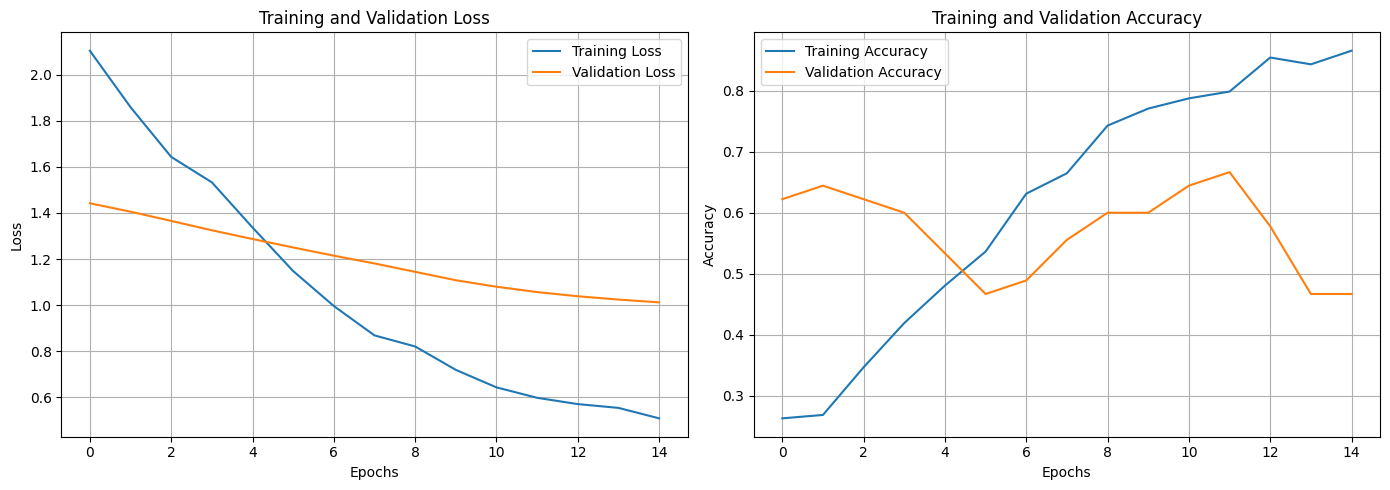

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

# Fungsi untuk plot training history (loss dan akurasi)
def plot_training_history(history):
    # Menentukan ukuran figure (2 grafik sejajar)
    plt.figure(figsize=(14, 5))  # Ukuran figure yang besar agar grafik terlihat jelas

    # Plot loss
    plt.subplot(1, 2, 1)  # Membuat subplot dengan 1 baris dan 2 kolom, grafik pertama
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Membuat subplot dengan 1 baris dan 2 kolom, grafik kedua
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()  # Menjaga jarak antar grafik agar lebih rapi
    plt.show()

# Panggil fungsi-fungsi ini setelah model selesai dilatih

# 1. Plot training history
print("Visualizing Training History...")
plot_training_history(history)

# Save Model h5



In [ ]:
# Save the model to a .h5 file
model.save('nutrition_grade_model.h5')
print("Model saved as nutrition_grade_model.h5")

Model saved as nutrition_grade_model.h5


# convert h5 to json

In [ ]:
# Install tensorflowjs

!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 110.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uni

In [ ]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras nutrition_grade_model.h5 tfjs_model

2024-12-06 13:12:35.577283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733490755.618363    3312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733490755.636256    3312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
